In [1]:
from collections import defaultdict
from copy import copy
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pipeGEM as pg
import seaborn as sns
from cobra import Metabolite, Model, Reaction
from cobra.flux_analysis.parsimonious import pfba
from cobra.flux_analysis.variability import flux_variability_analysis as fva
from cobra.io import load_model
from pipeGEM.data import GeneData
from pipeGEM.utils import random_perturb

# Q1

## Create the metabolites

In [2]:
metabolites = {
    "glucose": Metabolite("glucose"),
    "pyruvate": Metabolite("pyruvate"),
    "lactate": Metabolite("lactate"),
    "acetyl_CoA": Metabolite("acetyl_CoA"),
    "OAA": Metabolite("OAA"),
    "citrate": Metabolite("citrate"),
    "isocitrate": Metabolite("isocitrate"),
    "AKG": Metabolite("AKG"),
    "succinyl_CoA": Metabolite("succinyl_CoA"),
    "succinate": Metabolite("succinate"),
    "fumarate": Metabolite("fumarate"),
    "malate": Metabolite("malate"),
    "NAD+": Metabolite("NAD+"),
    "NADH": Metabolite("NADH"),
    "CO2": Metabolite("CO2"),
    "H2O": Metabolite("H2O"),
    "FAD": Metabolite("FAD"),
    "FADH2": Metabolite("FADH2"),
    "GDP": Metabolite("GDP"),
    "GTP": Metabolite("GTP"),
    "ADP": Metabolite("ADP"),
    "ATP": Metabolite("ATP"),
    "Q": Metabolite("Q"),
    "QH2": Metabolite("QH2"),
    "H+(i)": Metabolite("H+(i)"),
    "H+(m)": Metabolite("H+(m)"),
    "O2": Metabolite("O2"),
    "Cyt_c_ox": Metabolite("Cyt_c_ox"),
    "Cyt_c_red": Metabolite("Cyt_c_red"),
}

## Create the reactions

In [4]:
reactions = {
    "R1": {"glucose": 1},
    "R2": {
        "glucose": -1,
        "pyruvate": 2,
        "ADP": -2,
        "ATP": 2,
        "NAD+": -2,
        "NADH": 2,
    },
    "R3": {"pyruvate": -1, "lactate": 1, "NADH": -1, "NAD+": 1},
    "R4": {"pyruvate": -1, "acetyl_CoA": 1, "NAD+": -1, "NADH": 1, "CO2": 1},
    "R5": {"acetyl_CoA": -1, "OAA": -1, "citrate": 1},
    "R6": {"citrate": -1, "isocitrate": 1},
    "R7": {"isocitrate": -1, "AKG": 1, "NAD+": -1, "NADH": 1, "CO2": 1},
    "R8": {"AKG": -1, "succinyl_CoA": 1, "NAD+": -1, "NADH": 1, "CO2": 1},
    "R9": {"succinyl_CoA": -1, "succinate": 1, "GDP": -1, "GTP": 1},
    "R10": {"ATP": -1, "ADP": 1, "GDP": -1, "GTP": 1},
    "R11": {"succinate": -1, "fumarate": 1, "FAD": -1, "FADH2": 1},
    "R12": {"fumarate": -1, "malate": 1},
    "R13": {"malate": -1, "OAA": 1, "NAD+": -1, "NADH": 1},
    "R14": {"lactate": -1},
    "C1": {"Q": -1, "QH2": 1, "H+(m)": -5, "NADH": -1, "H+(i)": 4, "NAD+": 1},
    "C2": {"Q": -1, "QH2": 1, "FADH2": -1, "FAD": 1},
    "C3": {
        "QH2": -1,
        "Q": 1,
        "Cyt_c_ox": -2,
        "Cyt_c_red": 2,
        "H+(m)": -2,
        "H+(i)": 4,
    },
    "C4": {
        "Cyt_c_red": -2,
        "Cyt_c_ox": 2,
        "H+(m)": -4,
        "O2": -0.5,
        "H+(i)": 2,
        "H2O": 1,
    },
    "C5": {"H+(i)": -3, "ADP": -1, "H+(m)": 2, "ATP": 1, "H2O": 1},
}

exchange_reactions = {
    "In_NAD+": {"NAD+": 1},
    "Out_NADH": {"NADH": -1},
    "In_O2": {"O2": 1},
    "Out_CO2": {"CO2": -1},
    "Out_H2O": {"H2O": -1},
    "In_FAD": {"FAD": 1},
    "Out_FADH2": {"FADH2": -1},
    "In_GDP": {"GDP": 1},
    "Out_GTP": {"GTP": -1},
    "In_ADP": {"ADP": 1},
    "Out_ATP": {"ATP": -1},
    "In_Q": {"Q": 1},
    "Out_QH2": {"QH2": -1},
    "In_H+(m)": {"H+(m)": 1},
}

## Create a model and add the reactions

In [5]:
model = Model()

In [6]:
for rxn_id, stoich in reactions.items():
    rxn = Reaction(rxn_id)
    rxn.add_metabolites({metabolites[m]: coeff for m, coeff in stoich.items()})
    model.add_reactions([rxn])

model.reactions.R1.lower_bound = 0
model.reactions.R1.upper_bound = 25

for rxn_id, stoich in exchange_reactions.items():
    rxn = Reaction(rxn_id)
    rxn.add_metabolites({metabolites[m]: coeff for m, coeff in stoich.items()})
    rxn.lower_bound = 0
    rxn.upper_bound = 2000
    model.add_reactions([rxn])

## Perform pFBA

In [7]:
model.objective = "Out_ATP"
pfba(model)

,fluxes,reduced_costs
R1,2.500000e+01,-11.428571
R2,2.500000e+01,-2.000000
R3,-6.090366e-15,-2.000000
R4,5.000000e+01,-2.000000
R5,5.000000e+01,-2.000000
...,...,...
In_ADP,9.833333e+02,-2.000000
Out_ATP,9.833333e+02,-2.000000
In_Q,0.000000e+00,2.428571
Out_QH2,0.000000e+00,0.000000


# Q2

In [8]:
solution = fva(model, fraction_of_optimum=0)

In [16]:
c5_flux_range = solution.loc["C5"].iloc[1] - solution.loc["C5"].iloc[0]
c5_flux_range

933.3333333333336

In [ ]:
records = []
thres = c5_flux_range / 2

for i in range(len(model.reactions)):
    with model:
        model.reactions[i].knock_out()
        sol = fva(model, fraction_of_optimum=0)
        knock_flux_range = sol.loc["C5"].iloc[1] - sol.loc["C5"].iloc[0]
    if knock_flux_range < thres:
        records.append(model.reactions[i].id)

In [39]:
records

['R1',
 'R2',
 'R4',
 'R5',
 'R6',
 'R7',
 'R8',
 'R9',
 'R11',
 'R12',
 'R13',
 'C1',
 'C3',
 'C4',
 'C5',
 'In_O2',
 'Out_CO2',
 'Out_H2O',
 'In_GDP',
 'Out_GTP',
 'In_H+(m)']

# Q3

## Create upper bounds

In [66]:
upper_bounds = list(range(0, 1001, 100))

In [67]:
upper_bounds_2 = list(product(upper_bounds, upper_bounds))

## Iterate upper bounds & Perform pFBA

In [ ]:
r14_flux = defaultdict(list)
for rxn_id in [14, 16, 18]:
    for ub in upper_bounds:
        with model:
            model.reactions[rxn_id].upper_bound = ub
            df = pfba(model)
            r14_flux[model.reactions[rxn_id].id].append(df["R14"])

In [ ]:
for ub_c1, ub_c3 in upper_bounds_2:
    with model:
        model.reactions.C1.upper_bound = ub_c1
        model.reactions.C3.upper_bound = ub_c3
        df = pfba(model)
        r14_flux["C1+C3"].append(df["R14"])

## Visualization

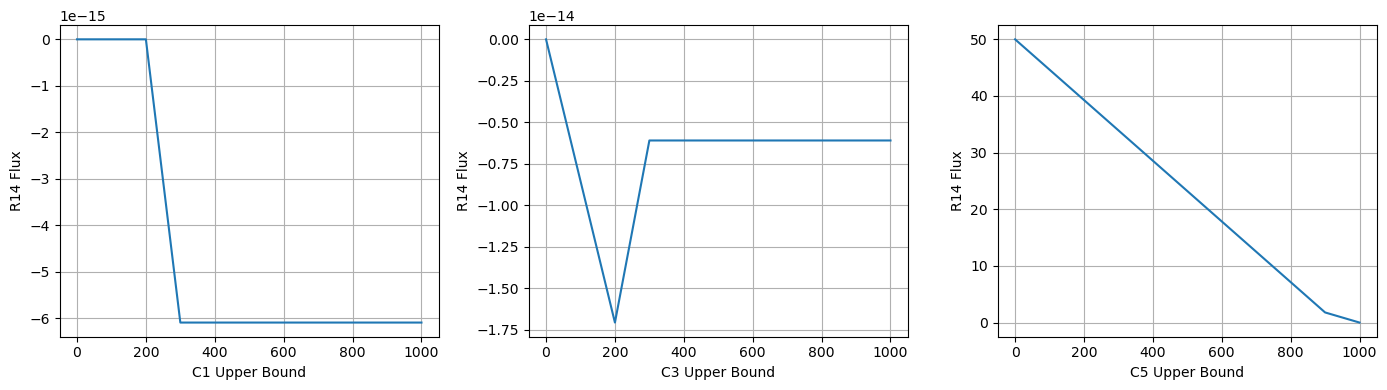

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
for i, (reaction, fluxes) in enumerate(r14_flux.items()):
    if reaction == "C1+C3":
        continue
    ax = axes[i]
    ax.plot(upper_bounds, fluxes, linestyle="-")
    ax.set_ylabel("R14 Flux")
    ax.grid(True)
    ax.set_xlabel(f"{reaction} Upper Bound")

plt.tight_layout()
plt.show()

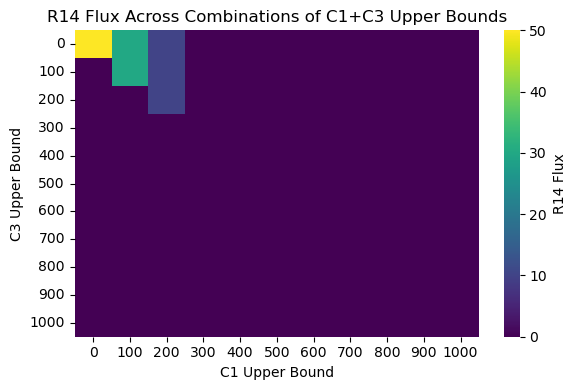

In [94]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    np.array(r14_flux["C1+C3"]).reshape(11, 11).T,
    xticklabels=upper_bounds,
    yticklabels=upper_bounds,
    cmap="viridis",
    cbar_kws={"label": "R14 Flux"},
)

plt.title("R14 Flux Across Combinations of C1+C3 Upper Bounds")
plt.xlabel("C1 Upper Bound")
plt.ylabel("C3 Upper Bound")
plt.tight_layout()
plt.show()

# Q4


In [2]:
raw_count = pd.read_csv("GSE291717_sysETS_TPM_File.csv", index_col=0)

In [3]:
textbook = load_model("textbook")
p_textbook = pg.Model("tttextbook", textbook)

In [4]:
rxn_scores = {}
for sample in raw_count.columns:
    gene_data = GeneData(
        data=raw_count[sample],
        data_transform=lambda x: np.log2(x + 1),
        absent_expression=0,
    )
    p_textbook.add_gene_data(
        name_or_prefix=sample,
        data=gene_data,
        or_operation="nanmax",
        and_operation="nanmin",
        threshold=-np.inf,
        absent_value=-np.inf,
    )

    rxn_scores[sample] = p_textbook.gene_data[sample].rxn_scores

100%|██████████| 95/95 [00:00<00:00, 14705.45it/s]


Finished mapping in 0.009131431579589844 seconds.


100%|██████████| 95/95 [00:00<00:00, 16262.96it/s]


Finished mapping in 0.007663726806640625 seconds.


100%|██████████| 95/95 [00:00<00:00, 12497.14it/s]


Finished mapping in 0.009227275848388672 seconds.


100%|██████████| 95/95 [00:00<00:00, 16669.83it/s]


Finished mapping in 0.007248640060424805 seconds.


100%|██████████| 95/95 [00:00<00:00, 15710.86it/s]


Finished mapping in 0.0077397823333740234 seconds.


100%|██████████| 95/95 [00:00<00:00, 16278.24it/s]


Finished mapping in 0.007302284240722656 seconds.


100%|██████████| 95/95 [00:00<00:00, 16300.22it/s]


Finished mapping in 0.0075070858001708984 seconds.


100%|██████████| 95/95 [00:00<00:00, 16326.94it/s]


Finished mapping in 0.007448434829711914 seconds.


100%|██████████| 95/95 [00:00<00:00, 16267.61it/s]


Finished mapping in 0.007456779479980469 seconds.


100%|██████████| 95/95 [00:00<00:00, 15889.42it/s]


Finished mapping in 0.0074465274810791016 seconds.


100%|██████████| 95/95 [00:00<00:00, 15772.43it/s]


Finished mapping in 0.007621288299560547 seconds.


100%|██████████| 95/95 [00:00<00:00, 16556.92it/s]


Finished mapping in 0.007228374481201172 seconds.


100%|██████████| 95/95 [00:00<00:00, 15474.73it/s]


Finished mapping in 0.009176254272460938 seconds.


100%|██████████| 95/95 [00:00<00:00, 15838.89it/s]


Finished mapping in 0.007594585418701172 seconds.


100%|██████████| 95/95 [00:00<00:00, 16626.01it/s]


Finished mapping in 0.007224082946777344 seconds.


100%|██████████| 95/95 [00:00<00:00, 15849.60it/s]


Finished mapping in 0.008053779602050781 seconds.


100%|██████████| 95/95 [00:00<00:00, 16434.68it/s]


Finished mapping in 0.0073702335357666016 seconds.


100%|██████████| 95/95 [00:00<00:00, 15550.83it/s]


Finished mapping in 0.008348226547241211 seconds.


100%|██████████| 95/95 [00:00<00:00, 16039.08it/s]


Finished mapping in 0.007472515106201172 seconds.


100%|██████████| 95/95 [00:00<00:00, 15611.76it/s]


Finished mapping in 0.007929563522338867 seconds.


100%|██████████| 95/95 [00:00<00:00, 15937.08it/s]


Finished mapping in 0.007512092590332031 seconds.


100%|██████████| 95/95 [00:00<00:00, 14909.59it/s]


Finished mapping in 0.008109569549560547 seconds.


100%|██████████| 95/95 [00:00<00:00, 13703.10it/s]


Finished mapping in 0.01050877571105957 seconds.


100%|██████████| 95/95 [00:00<00:00, 3510.00it/s]


Finished mapping in 0.03308534622192383 seconds.


100%|██████████| 95/95 [00:00<00:00, 12042.03it/s]


Finished mapping in 0.012013435363769531 seconds.


100%|██████████| 95/95 [00:00<00:00, 14184.57it/s]


Finished mapping in 0.009401082992553711 seconds.


100%|██████████| 95/95 [00:00<00:00, 16416.40it/s]


Finished mapping in 0.007434844970703125 seconds.


100%|██████████| 95/95 [00:00<00:00, 16059.77it/s]


Finished mapping in 0.0076177120208740234 seconds.


100%|██████████| 95/95 [00:00<00:00, 15697.25it/s]


Finished mapping in 0.0076487064361572266 seconds.


100%|██████████| 95/95 [00:00<00:00, 16629.48it/s]


Finished mapping in 0.007286787033081055 seconds.


100%|██████████| 95/95 [00:00<00:00, 16054.59it/s]


Finished mapping in 0.0075817108154296875 seconds.


100%|██████████| 95/95 [00:00<00:00, 16245.06it/s]


Finished mapping in 0.00747227668762207 seconds.


100%|██████████| 95/95 [00:00<00:00, 15080.57it/s]


Finished mapping in 0.008161544799804688 seconds.


100%|██████████| 95/95 [00:00<00:00, 16393.44it/s]


Finished mapping in 0.007670164108276367 seconds.


100%|██████████| 95/95 [00:00<00:00, 15534.46it/s]


Finished mapping in 0.0077686309814453125 seconds.


100%|██████████| 95/95 [00:00<00:00, 16345.69it/s]


Finished mapping in 0.0074427127838134766 seconds.


100%|██████████| 95/95 [00:00<00:00, 8932.05it/s]


Finished mapping in 0.012432098388671875 seconds.


100%|██████████| 95/95 [00:00<00:00, 8301.75it/s]


Finished mapping in 0.015608549118041992 seconds.


100%|██████████| 95/95 [00:00<00:00, 12400.69it/s]


Finished mapping in 0.011312723159790039 seconds.


100%|██████████| 95/95 [00:00<00:00, 12463.91it/s]

Finished mapping in 0.010452985763549805 seconds.


In [5]:
rxn_scores_df = pd.DataFrame.from_dict(rxn_scores)
rxn_scores_df

,WT_M9-glycerol-r1,WT_M9-glycerol-r2,u-ETS-1H_M9-glycerol-r1,u-ETS-1H_M9-glycerol-r2,u-ETS-2H_M9-glycerol-r1,u-ETS-2H_M9-glycerol-r2,u-ETS-3H_M9-glycerol -1,u-ETS-3H_M9-glycerol -2,u-ETS-4H_M9-glycerol-r1,u-ETS-4H_M9-glycerol-r2,...,SMOS-A_M9-succinate-r1,SMOS-A_M9-succinate-r2,e-Suc-ETS-1H-A_M9-succinate-r1,e-Suc-ETS-1H-A_M9-succinate-r2,e-Suc-ETS-2H-A_M9-succinate-r1,e-Suc-ETS-2H-A_M9-succinate-r2,e-Suc-ETS-3H-A_M9-succinate-r1,e-Suc-ETS-3H-A_M9-succinate-r2,e-Suc-ETS-4H-A_M9-succinate-r1,e-Suc-ETS-4H-A_M9-succinate-r2
ACALD,9.900128,9.935146,9.814510,11.053343,10.150890,10.327460,11.067143,10.845199,10.993799,10.863928,...,9.113849,9.311071,8.727840,8.050462,8.679931,9.210069,9.752530,9.539468,9.575032,9.365228
ACALDt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACKr,8.383695,8.409011,9.114158,10.249079,8.357923,8.431299,9.583119,9.540219,9.867344,9.762048,...,8.870076,9.201345,9.194469,8.775772,7.524495,7.979119,8.751541,8.408303,9.167442,8.990611
ACONTa,11.809894,11.836643,9.298450,10.152963,12.024525,12.057631,10.990629,10.539911,11.765361,11.720013,...,10.716109,9.649967,10.030350,9.231681,11.049414,11.117102,10.393028,10.206680,12.175244,12.045115
ACONTb,11.809894,11.836643,9.298450,10.152963,12.024525,12.057631,10.990629,10.539911,11.765361,11.720013,...,10.716109,9.649967,10.030350,9.231681,11.049414,11.117102,10.393028,10.206680,12.175244,12.045115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TALA,10.895711,10.956014,10.276429,10.986914,10.522225,10.597573,10.775028,10.622904,10.425806,10.354267,...,10.871293,10.877540,9.424532,9.279400,10.379510,10.670258,10.616515,10.427483,10.805950,10.810903
THD2,10.779859,10.758752,9.073923,9.248658,10.491322,10.517187,9.676694,9.636340,8.696724,8.787604,...,8.955122,7.908661,7.994533,7.595875,8.196021,7.943939,8.124174,8.173847,10.377073,10.516399
TKT1,10.322948,10.347145,9.191413,10.230755,10.255244,10.304432,10.286578,10.247466,10.072407,9.916333,...,10.166465,9.743072,9.041682,8.280467,9.091795,9.368019,9.530813,9.236504,10.643732,10.422535
TKT2,10.322948,10.347145,9.191413,10.230755,10.255244,10.304432,10.286578,10.247466,10.072407,9.916333,...,10.166465,9.743072,9.041682,8.280467,9.091795,9.368019,9.530813,9.236504,10.643732,10.422535


# Q5

In [6]:
th_90 = []
for sample in raw_count.columns:
    gene_data = GeneData(
        data=raw_count[sample],
        data_transform=lambda x: np.log2(x + 1),
        absent_expression=0,
    )
    p_threshold = gene_data.get_threshold("percentile", p=[90])
    # th_90.append(p_threshold.threshold_series["p=90"])
    th_90.append([sample, p_threshold.exp_th])


transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True
transform: True


In [7]:
th_90_df = pd.DataFrame(th_90).set_index(0)
print(th_90_df)

                                       1
0                                       
WT_M9-glycerol-r1               8.688831
WT_M9-glycerol-r2               8.690915
u-ETS-1H_M9-glycerol-r1         8.825239
u-ETS-1H_M9-glycerol-r2         8.923863
u-ETS-2H_M9-glycerol-r1         8.757602
u-ETS-2H_M9-glycerol-r2         8.655544
u-ETS-3H_M9-glycerol -1         8.867612
u-ETS-3H_M9-glycerol -2         8.944926
u-ETS-4H_M9-glycerol-r1         8.920378
u-ETS-4H_M9-glycerol-r2         8.894956
GlyMOS-A_M9-glycerol-r1         8.841393
GlyMOS-A_M9-glycerol-r2         8.932843
e-Gly-ETS-1H-A_M9-glycerol-r1   8.762081
e-Gly-ETS-1H-A_M9-glycerol-r2   8.766575
e-Gly-ETS-2H-A_M9-glycerol-r1   8.846630
e-Gly-ETS-2H-A_M9-glycerol-r2   8.958224
e-Gly-ETS-3H-A_M9-glycerol-r1   8.923998
e-Gly-ETS-3H-A_M9-glycerol-r2   8.984522
e-Gly-ETS-4H-A_M9-glycerol-r1   8.861065
e-Gly-ETS-4H-A_M9-glycerol-r2   8.816263
WT_M9-succinate-r1              8.730704
WT_M9-succinate-r2              8.555899
u-ETS-1H_M9-succ

# Q6

In [8]:
group = {}
for sample in raw_count.columns:
    result = p_textbook.integrate_gene_data(
        sample,
        integrator="GIMME",
        high_exp=th_90_df[1][sample],
        remove_zero_fluxes=True,
    )
    # group[sample] = [pg.Model(sample, result.result_model)]
    group[sample] = {sample: result.result_model}

original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64


c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users

original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64


c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users

original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64


c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users

original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64


c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users

original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64


c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users

original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64


c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users

original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64
original obj's optimized value:  Biomass_Ecoli_core    0.699137
Name: fluxes, dtype: float64


c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=
c:\Users\schen22_ad\miniconda3\envs\MSSB_HW3\Lib\site-packages\pipeGEM\integration\continuous\GIMME.py:63: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_remove = set(flux_df[abs(flux_df["fluxes"]).sort_index() <=


In [9]:
grp = pg.Group(group)
info_df = grp.get_info(features=["n_genes", "n_rxns", "n_mets"])
info_df

,n_genes,n_rxns,n_mets,group_name
WT_M9-glycerol-r1,92,50,52,WT_M9-glycerol-r1
WT_M9-glycerol-r2,92,50,52,WT_M9-glycerol-r2
u-ETS-1H_M9-glycerol-r1,98,52,54,u-ETS-1H_M9-glycerol-r1
u-ETS-1H_M9-glycerol-r2,98,52,54,u-ETS-1H_M9-glycerol-r2
u-ETS-2H_M9-glycerol-r1,83,48,50,u-ETS-2H_M9-glycerol-r1
u-ETS-2H_M9-glycerol-r2,83,48,50,u-ETS-2H_M9-glycerol-r2
u-ETS-3H_M9-glycerol -1,92,50,52,u-ETS-3H_M9-glycerol -1
u-ETS-3H_M9-glycerol -2,98,52,54,u-ETS-3H_M9-glycerol -2
u-ETS-4H_M9-glycerol-r1,83,48,50,u-ETS-4H_M9-glycerol-r1
u-ETS-4H_M9-glycerol-r2,83,48,50,u-ETS-4H_M9-glycerol-r2


# Q7

In [10]:
wt1_model = group["WT_M9-glycerol-r1"]["WT_M9-glycerol-r1"]
wt2_model = group["WT_M9-glycerol-r2"]["WT_M9-glycerol-r2"]
suc1_model = group["u-ETS-4H_M9-succinate-r1"]["u-ETS-4H_M9-succinate-r1"]
suc2_model = group["u-ETS-4H_M9-succinate-r2"]["u-ETS-4H_M9-succinate-r2"]

In [11]:
group = pg.Group(
    {
        "WT": {"wt1": wt1_model, "wt2": wt2_model},
        "succinate": {"suc_1": suc1_model, "suc2": suc2_model},
    }
)

In [ ]:
# Encounter GPR.__init__() takes from 1 to 2 positional arguments but 3 were given
# Thus, rewrite the cobra function to fix it.
from copy import deepcopy

import cobra


def fixed_copy(self):
    """Copy a GPR."""
    gpr = cobra.core.gene.GPR("")
    gpr._genes = deepcopy(self._genes)
    return gpr


def fixed_copy_shallow(self):
    """Ensure a correct shallow copy."""
    gpr = cobra.core.gene.GPR("")
    gpr._genes = copy(self._genes)
    return gpr


cobra.core.gene.GPR.copy = fixed_copy
cobra.core.gene.GPR.__copy__ = fixed_copy_shallow

In [ ]:
sampling_result = group.do_flux_analysis(
    method="sampling",
    n=100,
    solver="glpk",
)

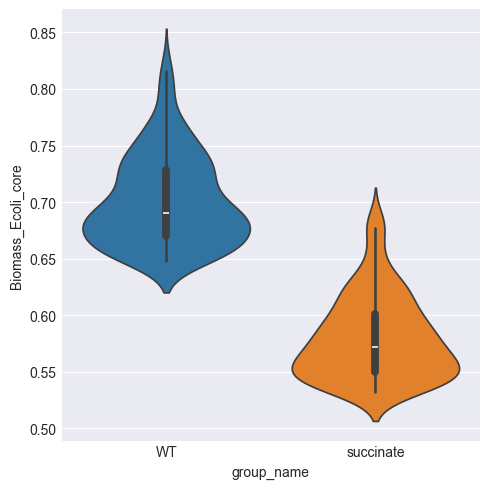

In [ ]:
sampling_result.plot(
    rxn_id="Biomass_Ecoli_core",
    plotting_type="catplot",
    kind="violin",
    group_by="group_name",
)